### Deliverable 3: Optimize the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("./Resources/charity_data.csv")
print(application_df.shape)
application_df.head()

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

(34299, 12)


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN","NAME"])
print(application_df.shape)
application_df.head()

(34299, 10)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

### Drop noisy or unless columns 

In [4]:
# Among those applications with STATUS = 0, check how many of the applications are failure
application_df[(application_df.STATUS == 0) & (application_df.IS_SUCCESSFUL == 0)]

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
20518,T3,CompanySponsored,C2100,CommunityServ,Association,0,0,N,5000,0
29590,T3,Independent,C1000,Preservation,Association,0,0,N,5000,0


Since there is only 2 records with STATUS=0 and application is fail, this STATUS column may not provide much information for prediction, thus we drop this column from the potential features

In [5]:
application_df = application_df.drop(columns=["STATUS"])
print(application_df.shape)
application_df.head()

(34299, 9)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


<AxesSubplot:>

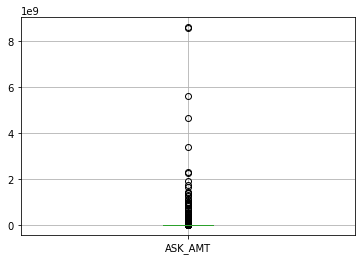

In [6]:
application_df.boxplot(column="ASK_AMT")

Since the 'APPLICATION_TYPE' and 'CLASSIFICATION' have more than 10 unique values, they need for binning

In [7]:
# Look at APPLICATION_TYPE value counts for binning
application_type_counts = application_df.APPLICATION_TYPE.value_counts()
application_type_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

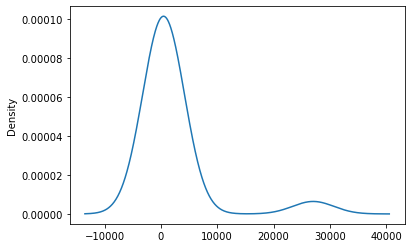

In [8]:
# Visualize the value counts of APPLICATION_TYPE
application_type_counts.plot.density()

In [9]:
# Determine which values to replace if counts are less than 500
replace_application = list(application_type_counts[application_type_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [10]:
# Look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

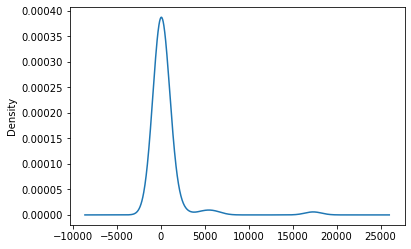

In [11]:
# Visualize the value counts of CLASSIFICATION
classification_counts.plot.density()

**Create more bins and decrease the number of values for each bin under CLASSIFICATION**

In [12]:
# Determine which values to replace if counts are less than 150
replace_class = list(classification_counts[classification_counts < 150].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1003
C7000      777
C1700      287
C4000      194
Name: CLASSIFICATION, dtype: int64

In [13]:
# Generate the categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [14]:
# Check the number of unique values in each categorical column
application_df[application_cat].nunique()

APPLICATION_TYPE          9
AFFILIATION               6
CLASSIFICATION            9
USE_CASE                  5
ORGANIZATION              4
INCOME_AMT                9
SPECIAL_CONSIDERATIONS    2
dtype: int64

In [15]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
print(encode_df.shape)
encode_df.head()

(34299, 44)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(labels=application_cat,axis=1)
print(application_df.shape)
application_df.head()

(34299, 46)


,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Split our preprocessed data into our features and target arrays

# We need to keep the "IS_SUCCESSFUL" column as the 'Target output'.
y = application_df["IS_SUCCESSFUL"].values
# Drop 'IS_SUCCESSFUL' from the 'Input Values'
X = application_df.drop(labels=["IS_SUCCESSFUL"],axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [18]:
# Standardize the numerical features

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 120
hidden_nodes_layer2 = 60
hidden_nodes_layer3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               5520      
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 14,641
Trainable params: 14,641
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Define the batch size
batch_size = 804

# Create a callback that saves the model's weights every 5 epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*batch_size)

In [22]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 949us/step - loss: 0.5691 - accuracy: 0.7198
Epoch 2/100
804/804 [==============================] - 1s 943us/step - loss: 0.5552 - accuracy: 0.7283
Epoch 3/100
804/804 [==============================] - 1s 932us/step - loss: 0.5524 - accuracy: 0.7301
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5497 - accuracy: 0.7300
Epoch 5/100
800/804 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7314
Epoch 5: saving model to checkpoints\weights.05.hdf5
804/804 [==============================] - 1s 971us/step - loss: 0.5479 - accuracy: 0.7314
Epoch 6/100
804/804 [==============================] - 1s 953us/step - loss: 0.5458 - accuracy: 0.7342
Epoch 7/100
804/804 [==============================] - 1s 943us/step - loss: 0.5452 - accuracy: 0.7339
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5441 - accuracy: 0.7343
Epoch 9/100
804/804 [=====================

804/804 [==============================] - 1s 913us/step - loss: 0.5311 - accuracy: 0.7410
Epoch 65/100
798/804 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7414
Epoch 65: saving model to checkpoints\weights.65.hdf5
804/804 [==============================] - 1s 969us/step - loss: 0.5307 - accuracy: 0.7413
Epoch 66/100
804/804 [==============================] - 1s 991us/step - loss: 0.5302 - accuracy: 0.7415
Epoch 67/100
804/804 [==============================] - 1s 957us/step - loss: 0.5305 - accuracy: 0.7412
Epoch 68/100
804/804 [==============================] - 1s 924us/step - loss: 0.5301 - accuracy: 0.7401
Epoch 69/100
804/804 [==============================] - 1s 933us/step - loss: 0.5300 - accuracy: 0.7410
Epoch 70/100
766/804 [===========================>..] - ETA: 0s - loss: 0.5296 - accuracy: 0.7413
Epoch 70: saving model to checkpoints\weights.70.hdf5
804/804 [==============================] - 1s 939us/step - loss: 0.5300 - accuracy: 0.7410
Epoch 7

<AxesSubplot:>

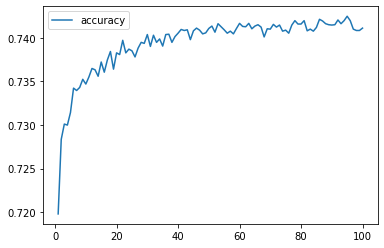

In [23]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5593 - accuracy: 0.7283 - 248ms/epoch - 924us/step
Loss: 0.5592551231384277, Accuracy: 0.7282798886299133


In [25]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")